![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Understanding Computer Vision Tasks

Now that Kevin has a better understanding of how computer vision classification works, he needs to learn more about other computer vision tasks. His manager has asked him to move on from wasps and bees to... fruits and (bounding) boxes! Kevin thankfully has an annotated dataset already, so he can start learning about object detection.

As before, the dataset was found on. [Check out the dataset information](https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection/data)

![Image of fruits and bounding boxes from the dataset cover image](notebook_images/fruits_detection_dataset-cover.jpg)

This notebook will be a bit different than the previous ones: it doesn't use TensorFlow or Keras. Instead, it uses PyTorch, torchvision and YOLOv8. Whereas TensorFlow and Keras are easier to use for a variety of deep learning tasks (such as image classification), PyTorch is more popular and currently better suited for object detection. YOLOv8 (You Only Look Once, version 8) is a popular object detection model that is known for its speed, accuracy and relative ease of implementation.

As we've mentioned before, these tools are rapidly evolving, so it's important to stay up-to-date with the latest versions and best practices.



## 1.  Import the libraries we will use

In [1]:
# This notebook will be used for an Object Detection task that trains a model on the fruits_detection dataset using YOLOv8

# Importing the necessary libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch
import yaml 
from ultralytics import YOLO


import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')




Training on cpu


## 2. Getting the data

As we did in Notebook 1, we will have to download the dataset. This time the file is stored as a zip file, so we will need to extract it. 

You will also notice that instead of loading things to the **data** directory, the data is instead loaded to a new folder called **datasets**. This is a requirement of YOLOv8, which expects the data to be in a specific folder. The setting is *technically* possible to change, but is not something we want to hassle with right now.

In [3]:
def download_file(url="https://www.dropbox.com/scl/fi/ioupfqya76b7p8m1v1kdc/fruits_detection.zip?rlkey=ofgre83fdxa98p7ity8j9z8ip&st=atv7sz18&dl=1", filename="fruits_detection.zip"):
                        
    # Check to see if the datasets folder exists
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # Download the file using requests
    response = requests.get(url, stream=True)

    # Create a file object and write the response content in chunks
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Wait for the file to finish downloading
    while not os.path.exists(filename):
        time.sleep(1)

    # Print a success message
    print(f"Downloaded {filename} successfully.")

def extract_file(filename, data_folder):
    # Check if the file is a zip file
    if zipfile.is_zipfile(filename):
        # Open the zip file
        with zipfile.ZipFile(filename, "r") as zip_ref:
            # Extract all the files to the data folder
            zip_ref.extractall(data_folder)
            # Print a success message
            print(f"Extracted {filename} to {data_folder} successfully.")
    else:
        # Print an error message
        print(type(filename))
        print(f"{filename} is not a valid zip file.")
    
def manage_data(folder_name='fruits_detection'):
    '''Try to find the data for the exercise and return the path'''
    
    # Check common paths of where the data might be on different systems
    likely_paths= [os.path.normpath(f'/blue/practicum-ai/share/data/{folder_name}'),
                   os.path.normpath(f'/project/scinet_workshop2/data/{folder_name}'),
                   os.path.join('datasets', folder_name),
                   os.path.normpath(folder_name)]
    
    for path in likely_paths:
        if os.path.exists(path):
            print(f'Found data at {path}.')
            return path

    answer = input(f'Could not find data in the common locations. Do you know the path? (yes/no): ')

    if answer.lower() == 'yes':
        path = os.path.join(os.path.normpath(input('Please enter the path to the data folder: ')),folder_name)
        if os.path.exists(path):
            print(f'Thanks! Found your data at {path}.')
            return path
        else:
            print(f'Sorry, that path does not exist.')
    
    answer = input('Do you want to download the data? (yes/no): ')

    if answer.lower() == 'yes':

        ''' Check and see if the downloaded data is inside the .gitignore file, and adds them to the list of files to ignore if not. 
        This is to prevent the data from being uploaded to the repository, as the files are too large for GitHub.'''
        
        if os.path.exists('.gitignore'):
            with open('.gitignore', 'r') as f:
                ignore = f.read().split('\n')
        # If the .gitignore file does not exist, create a new one
        elif not os.path.exists('.gitignore'):
            with open('.gitignore', 'w') as f:
                f.write('')
            ignore = []
        else:
            ignore = []

        # Check if the .gz file is in the ignore list
        if 'fruits_detection.zip' not in ignore:
            ignore.append('fruits_detection.zip')
            
        # Check if the data/ folder is in the ignore list
        if 'datasets/' not in ignore:
            ignore.append('datasets/')

        # Write the updated ignore list back to the .gitignore file
        with open('.gitignore', 'w') as f:
            f.write('\n'.join(ignore))

        print("Updated .gitignore file.")
        print('Downloading data, this may take a minute.')
        download_file()
        print('Data downloaded, unpacking')
        extract_file("fruits_detection.zip", "datasets")
        print('Data downloaded and unpacked. Now available at datasets/fruits_detection.')
        return os.path.normpath('datasets/fruits_detection')   

    print('Sorry, I cannot find the data. Please download it manually from https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection/ and unpack it to the datasets folder.')      


data_path = manage_data() 

Found data at datasets\fruits_detection.


## 3. Explore the dataset

We will take a look at the dataset to see what it contains. We will also look at the annotations file, which contains the bounding box information for each image.

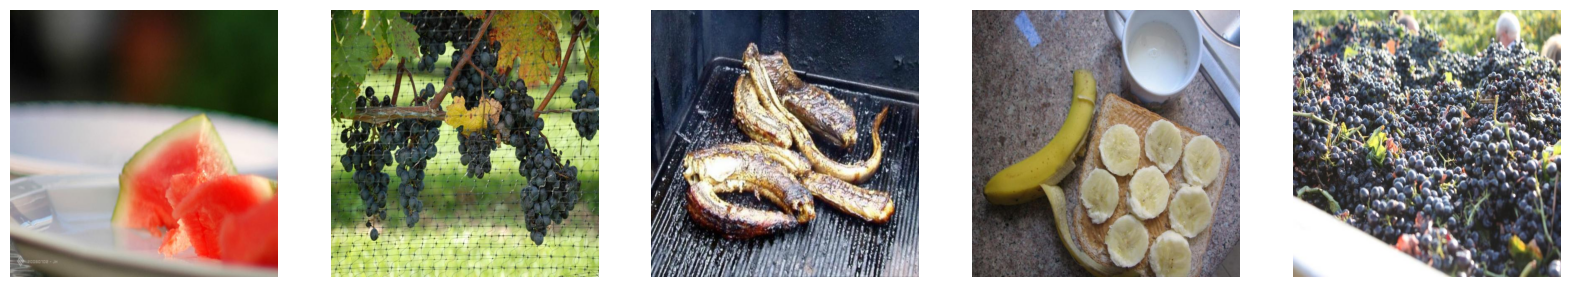

File: datasets/fruits_detection\test\labels\000aee0af66d4237_jpg.rf.6b99256606e5b7a1ede8b833a87196a7.txt
  5 0.5203125 0.7375 0.54609375 0.3265625
File: datasets/fruits_detection\test\labels\000d9c59687b509b_jpg.rf.c338360b3dfe1953a5d266ee861d7e79.txt
  0 0.1890625 0.18984375 0.378125 0.37890625
  0 0.5765625 0.621875 0.5921875 0.4859375
  0 0.36640625 0.509375 0.0390625 0.05234375
File: datasets/fruits_detection\test\labels\000e4e7ed48c932d_jpg.rf.8233751e16b32b9470e45c6135c8f8c7.txt
  3 0.4703125 0.7484375 0.28984375 0.4421875
File: datasets/fruits_detection\test\labels\00149fd0a01cc623_jpg.rf.68e2b35f1bc31938c4a10d32a8f5340e.txt
  3 0.72734375 0.32109375 0.29765625 0.4265625
File: datasets/fruits_detection\test\labels\006e0a3d99d16d60_jpg.rf.258f5af33beab4d59918218c732de430.txt
  2 0.48671875 0.56015625 0.51171875 0.6203125


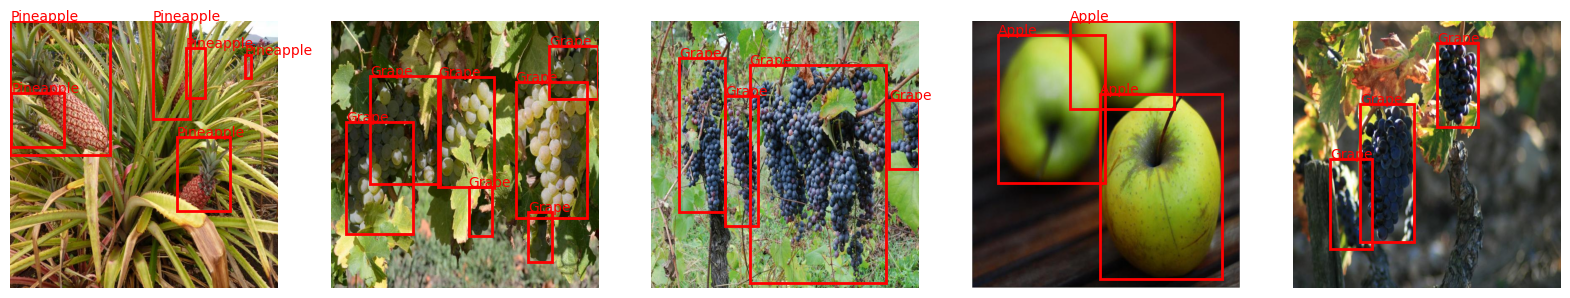

In [11]:
# Assign the path to the dataset
data_dir = r"datasets/fruits_detection"

# Make a histogram of the number of images in each class
def explore_data(data_dir, show_picture=True, show_annotation=True, show_detection=True, show_hist=True):

    # Define the class names
    class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']
    
    # Examine some sample images
    if show_picture:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_dir, folder, 'images', random.choice(os.listdir(os.path.join(data_dir, folder, 'images'))))
            sample_images.append(img_path)

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

    # Examine the first five annotation files
    if show_annotation:
        annotation_files = []
        for folder in os.listdir(data_dir):
            if os.path.isdir(os.path.join(data_dir, folder)):
                annotation_folder = os.path.join(data_dir, folder, 'labels')
                if os.path.exists(annotation_folder):
                    for file in os.listdir(annotation_folder):
                        annotation_files.append(os.path.join(annotation_folder, file))
        for file in annotation_files[:5]:
            with open(file, 'r') as f:
                print(f"File: {file}")
                for i, line in enumerate(f):
                    if i > 4:
                        break
                    print(f"  {line.strip()}")

    # Plot five random images with their associated, labeled bounding boxes
    if show_detection:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_dir, folder, 'images', random.choice(os.listdir(os.path.join(data_dir, folder, 'images'))))
            annotation_path = os.path.join(data_dir, folder, 'labels', os.path.basename(img_path).replace('.jpg', '.txt'))
            sample_images.append((img_path, annotation_path))

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, (img_path, annotation_path) in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            with open(annotation_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    x, y, w, h = x * img.width, y * img.height, w * img.width, h * img.height
                    rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='red', linewidth=2)
                    axes[i].add_patch(rect)
                    # Add class name above the bounding box
                    axes[i].text(x - w / 2, y - h / 2, class_names[int(class_id)], color='red')
        plt.show()


    # Make a histogram of the number of images in each class
    if show_hist:
        def get_class_counts(folder_path):  # Change from data_dir to folder_path
            class_counts = {}
            labels_path = os.path.join(folder_path, 'labels')  # Add labels path
            for filename in os.listdir(labels_path):  # Update listdir
                with open(os.path.join(labels_path, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split(' ')[0])  # Assuming labels are in YOLO format
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
            return class_counts

        train_counts = get_class_counts(os.path.join(data_dir, 'train'))  # Add os.path.join
        val_counts = get_class_counts(os.path.join(data_dir, 'valid'))
        test_counts = get_class_counts(os.path.join(data_dir, 'test'))
        num_classes = len(class_names)

        data_counts = {
            'train': pd.Series(train_counts),
            'val': pd.Series(val_counts),
            'test': pd.Series(test_counts)
        }
        df = pd.DataFrame(data_counts)

        df.plot.bar(figsize=(10, 6))
        plt.xlabel('Class Name')
        plt.xticks(np.arange(num_classes), class_names)
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images per Class')
        plt.legend()
        plt.show()

explore_data(data_dir, show_picture=True, show_annotation=True, show_detection=True, show_hist=True)

There's a lot to unpack here! First, depending on the images sampled, we can see that the images are of different sizes and have different numbers of fruits. Other things to note:
- Some of the images don't really contain fruits...
- The file names are the same as the image names, but with a .txt extension.
- The annotations file contains the class ID of the fruit (0 corresponds to 'Apple', etc.), and the bounding box coordinates. 
- The bounding box coordinates are in the format (x_min, y_min, x_max, y_max).
- The bounding box coordinates are normalized, meaning that they are scaled to be between 0 and 1. This is a common practice in object detection tasks.
- The bounding boxes in some of the images are not very accurate. This is a common problem in object detection tasks.
- The dataset is very imbalanced, with a lot more oranges than other fruits.

# Create the YAML file

In [4]:
# Create a YAML file for the YOLOv8 model configuration

def create_yaml(data_dir, class_names, yaml_file='fruits_detection_data.yaml'):
    """
    Creates a YOLOv8 data.yaml file. YAML stands for "YAML Ain't Markup Language" and is a human-readable data serialization format.
    A YAML file is used to define the dataset configuration for training a YOLOv8 model.

    Args:
        data_dir (str): Path to the dataset root directory.
        class_names (list): List of class names.
        yaml_file (str): Name of the YAML file to save. Defaults to 'data.yaml'.
    """

    yaml_dict = {
        # 'path': data_dir,  # Path to your dataset
        'train': data_dir + '/train/images',  # Relative path to training images
        'val': data_dir + '/valid/images',    # Relative path to validation images
        'test': data_dir + '/test/images',    # Relative path to testing images

        'num_classes': len(class_names),   # Number of classes
        'names': class_names      # List of class names
    }

    with open(yaml_file, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

    print(f'YAML file created: {yaml_file}')

data_dir = 'fruits_detection'
class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']

create_yaml(data_dir, class_names) 

YAML file created: fruits_detection_data.yaml


# Create the model

In [5]:
# Make the YOLOv8 model
model = YOLO('yolov8n.yaml')
results = model.train(data='fruits_detection_data.yaml', imgsz=640, epochs=3)

New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.9 🚀 Python-3.8.18 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81051MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=fruits_detection_data.yaml, epochs=3, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning /home/i.lutticken/computer_vision/datasets/fruits_detection/train/labels... 7108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:02<00:00, 3219.82it/s]

train: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.0d7b6d095459cece040b47b246d807af.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.64e869a9bedd5f012cc2a1129c6ca229.jpg: 1 duplicate labels removed


train: New cache created: /home/i.lutticken/computer_vision/datasets/fruits_detection/train/labels.cache


/home/i.lutticken/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /home/i.lutticken/computer_vision/datasets/fruits_detection/valid/labels... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:00<00:00, 2336.51it/s]

val: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed


val: New cache created: /home/i.lutticken/computer_vision/datasets/fruits_detection/valid/labels.cache


/home/i.lutticken/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.84G      3.129      4.083       3.71         75        640: 100%|█████████▉| 444/445 [01:08<00:00,  7.26it/s]/home/i.lutticken/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
        1/3      2.89G      3.127      4.082      3.708         45        640: 100%|██████████| 445/445 [01:09<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]

                   all        914       3227      0.205     0.0446      0.014    0.00541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      3.05G      2.093      3.262       2.53         18        640: 100%|██████████| 445/445 [01:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


                   all        914       3227      0.266      0.103     0.0522      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      3.09G       1.76      2.859      2.153         27        640: 100%|██████████| 445/445 [01:05<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


                   all        914       3227      0.323      0.147     0.0792     0.0407

3 epochs completed in 0.063 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.8.18 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81051MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.57it/s]


                   all        914       3227      0.323      0.147      0.079     0.0407
                 Apple        914        557      0.191      0.208      0.101     0.0609
                Banana        914        390      0.163      0.041     0.0433     0.0155
                 Grape        914        809      0.228      0.063     0.0414     0.0158
                Orange        914       1100      0.169       0.39      0.174     0.0896
             Pineapple        914        154          1          0      0.013    0.00513
            Watermelon        914        217      0.186       0.18      0.101     0.0571
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train5


In [5]:
# Run the model on a test image
img = 'datasets/fruits_detection/test/images/Apple_1.jpg'
results = model(img)
results.show()



NameError: name 'model' is not defined